In [165]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import itertools
from functools import reduce

In [166]:
N = 2
dev = qml.device('default.qubit', wires=N)

In [167]:
from sklearn.datasets import load_breast_cancer
from sklearn.utils.random import sample_without_replacement

bc = load_breast_cancer()
idx = sample_without_replacement(len(bc.data), 20, random_state=100)
bc.data = bc.data[idx]
bc.target = bc.target[idx]

bc.target = np.array([1 if y == 0 else -1 for y in bc.target])
                      
print(bc.target)

[ 1 -1  1 -1 -1 -1  1  1  1 -1 -1  1  1  1 -1  1  1 -1 -1 -1]


In [168]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

ss = preprocessing.StandardScaler()
bc_stand = ss.fit(bc.data).transform(bc.data)

pca = PCA(n_components=N)
bc_pca = pca.fit(bc_stand).transform(bc_stand)

#print("explained variance: ", pca.explained_variance_ratio_)  
#print("singular values: ", pca.singular_values_) 

scaler = preprocessing.MinMaxScaler(feature_range=(0, np.pi))
bc_norm = scaler.fit(bc_pca).transform(bc_pca)

bc_proc = bc_norm
num_data = len(bc.target)
    
#print("data length: ", num_data)
#print(bc_proc)

Now we add implicit features corresponding to the two-point all-pairs parity

$$
\phi_{i, j}(x) = (\pi - x_i)(\pi - x_j)
$$

In [169]:
#print("train data: ", train_data)
#print("test data: ", test_data)

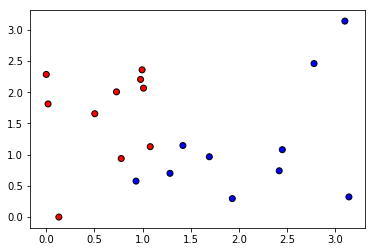

In [170]:
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

plt.figure()
plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc.target,cmap=cm_bright, edgecolors='k')
plt.show()

In [171]:
#import sys
#import numpy
#numpy.set_printoptions(threshold=sys.maxsize)

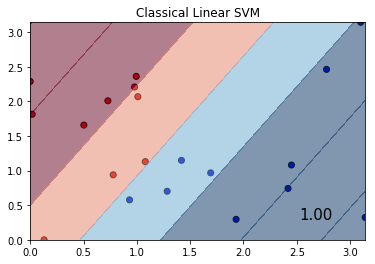

In [172]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(bc_proc.data, bc.target)

score = clf.score(bc_proc.data, bc.target)

x_min = y_min = 0
x_max = y_max = np.pi
h = .02  # step size in the mesh

cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(grid) 
Z = Z.reshape(xx.shape)

#for i in range(int(x_max / h)):
#    if Z[0, i] > 0:
#        print(Z[0, i], grid[i])

plt.figure()

plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc.target, cmap=cm_bright, edgecolors='k')
plt.contourf(xx, yy, Z, vmin=-1., vmax=1., cmap=cm, alpha=.5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.title("Classical Linear SVM")
plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')

plt.show()

In [173]:
def U_phi(x):
    # x_2 = (pi - x_0)(pi - x_1)
    
    for i in range(N):
        qml.RZ( x[i], wires=0)
    
    
    for (j, pair) in enumerate(itertools.combinations(range(N), r=2)):
        qml.CNOT(wires=[pair[0], pair[1]])
        qml.RZ(x[N + j], pair[1])
        qml.CNOT(wires=[pair[0], pair[1]])

In [174]:
def featuremap(x):
    for i in range(2):
        for j in range(N):
            qml.Hadamard(wires=j)
        U_phi(x)

In [175]:
def layer(W): # 6 weights are specified at each layer
    
    for i in range(N): 
        if i == (N-1):
            qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
            qml.Rot(W[N-1, 0], W[N-1, 1], W[N-1, 2], wires=N-1)
            
            qml.CNOT(wires=[0, N-1])
        else: 
            # euler angles
            qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
            qml.Rot(W[i+1, 0], W[i+1, 1], W[i+1, 2], wires=i + 1)

            qml.CNOT(wires=[i, i+1])

In [176]:
@qml.qnode(dev)
def circuit(weights, x, n=0):

    featuremap(x)

    for W in weights:
        layer(W)

    return qml.expval.PauliZ(wires=n)

In [177]:
def variational_classifier(var, x): # x is a keyword argument -> fixed (not trained)
    weights = var[0]
    bias = var[1]
    
    exp_Z = circuit(weights, x, n=0)
    for i in range(1, N):
        #print("computing expectation at index {0}".format(i))
        e = circuit(weights,x,n=i)
        exp_Z *= e

    return exp_Z + bias

In [178]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)

    return loss

In [179]:
def accuracy(labels, predictions):
    #print(labels, predictions)
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [180]:
def cost(var, X, Y):

    predictions = [variational_classifier(var, x) for x in X]
    #if (len(Y) == num_data):
    #    print("[(pred, label), ...]: ", list(zip(predictions, Y)))
    
    sq_l = square_loss(Y, predictions) 
    
    #print("square loss: ", sq_l)
    return sq_l

In [181]:
num_iterations = 20

def train_and_test(X, Y):
    opt = NesterovMomentumOptimizer(0.01)
    batch_size = 5
    var_init = (0.01 * np.random.randn(layers, N, 3), 0.0)

    # train the variational classifier
    var = var_init
    
    min_cost = 100.
    min_cost_var = []
    
    train_accuracies = []
    costs = []
    for it in range(num_iterations):

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, num_train, (batch_size, ))
        X_train_batch = X[batch_index]
        Y_train_batch = Y[batch_index]
        var = opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), var)
        #print("Var: ", var)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(var, f)) for f in X]

        # Compute accuracy on train and validation set
        acc_train = accuracy(Y, predictions_train)
        
        # Compute cost on all samples
        c = cost(var, X, Y)
        
        if c < min_cost:
            min_cost = c
            min_cost_var = var
            
        costs.append(c)
        train_accuracies.append(acc_train)
        
        print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} "
              "".format(it+1, c, acc_train))
        
    return train_accuracies, costs, min_cost_var

In [162]:
from scipy.special import comb

#thresholds = [0.0, 0.1, 0.2, 0.3]
gammas = [0.0, 0.25, 0.5, 1.0, 1.5, 2.0]
gam_test_accuracies = []
gam_train_accuracies = []
gam_costs = []
gam_vars = []
    
for g in gammas:
        print("gamma: ", g)
        new_features = np.zeros((num_data, int(comb(N, 2))))

        for i in range(num_data):
            for (j, pair) in enumerate(itertools.combinations(range(N), r=2)):
                new_features[i, j] = g * (np.pi - bc_proc[i, pair[0]]) * (np.pi - bc_proc[i, pair[1]])

        all_data = np.append(bc_proc, new_features, 1)
        print(np.shape(bc_proc), np.shape(new_features), np.shape(all_data))

        train_data, test_data, train_label, test_label = train_test_split(
            all_data, bc.target, test_size = 0.2, random_state=1)

        num_train = int(0.8 * num_data)
        
        trn_ac, tst_ac, costs, var = train_and_test(
            all_data, bc.target, train_data, train_label, test_data, test_label)
        gam_train_accuracies.append(trn_ac)
        gam_test_accuracies.append(tst_ac)
        gam_costs.append(costs)
        gam_vars.append(var)
        print("Var: ", var)

gamma:  0.0
(20, 2) (20, 1) (20, 3)


TypeError: train_and_test() takes 2 positional arguments but 6 were given

In [184]:
from scipy.special import comb

num_layers = [1]
    
new_features = np.zeros((num_data, int(comb(N, 2))))

for i in range(num_data):
    for (j, pair) in enumerate(itertools.combinations(range(N), r=2)):
        new_features[i, j] = (np.pi - bc_proc[i, pair[0]]) * (np.pi - bc_proc[i, pair[1]])

all_data = np.append(bc_proc, new_features, 1)

print(np.shape(bc_proc), np.shape(new_features), np.shape(all_data))

for layers in num_layers:
        print("layers: ", layers)
        
        layers_train_accs = []
        layers_vars = []
        layers_costs = []

        for shot in range(5):
            print("Shot: ", shot)
            trn_ac, costs, var = train_and_test(
                all_data, bc.target)
        
            layers_train_accs.append(trn_ac)
            layers_costs.append(costs)
            layers_vars.append(var)
            print("Var: ", var)
            
        layer_train_acc_map[layers] = layers_train_accs
        layer_cost_map[layers] = layers_costs
        layer_var_map[layers] = layers_vars

(20, 2) (20, 1) (20, 3)
layers:  1
Shot:  0
Iter:     1 | Cost: 1.3199010 | Acc train: 0.6000000 
Iter:     2 | Cost: 1.3124021 | Acc train: 0.6500000 
Iter:     3 | Cost: 1.3036618 | Acc train: 0.6500000 
Iter:     4 | Cost: 1.3005423 | Acc train: 0.6000000 
Iter:     5 | Cost: 1.2975552 | Acc train: 0.6000000 
Iter:     6 | Cost: 1.2954863 | Acc train: 0.6000000 
Iter:     7 | Cost: 1.2934486 | Acc train: 0.5500000 
Iter:     8 | Cost: 1.2962957 | Acc train: 0.5000000 
Iter:     9 | Cost: 1.3006052 | Acc train: 0.5000000 
Iter:    10 | Cost: 1.3008837 | Acc train: 0.4500000 
Iter:    11 | Cost: 1.3000059 | Acc train: 0.5000000 
Iter:    12 | Cost: 1.3015872 | Acc train: 0.4500000 
Iter:    13 | Cost: 1.3033688 | Acc train: 0.4500000 
Iter:    14 | Cost: 1.3005696 | Acc train: 0.4500000 
Iter:    15 | Cost: 1.2969598 | Acc train: 0.4500000 
Iter:    16 | Cost: 1.2928090 | Acc train: 0.4500000 
Iter:    17 | Cost: 1.2905755 | Acc train: 0.4500000 
Iter:    18 | Cost: 1.2887646 | Acc tr

In [ ]:
print(layer_train_acc_map[3])
print(layer_cost_map[3])
print(layer_var_map[3])

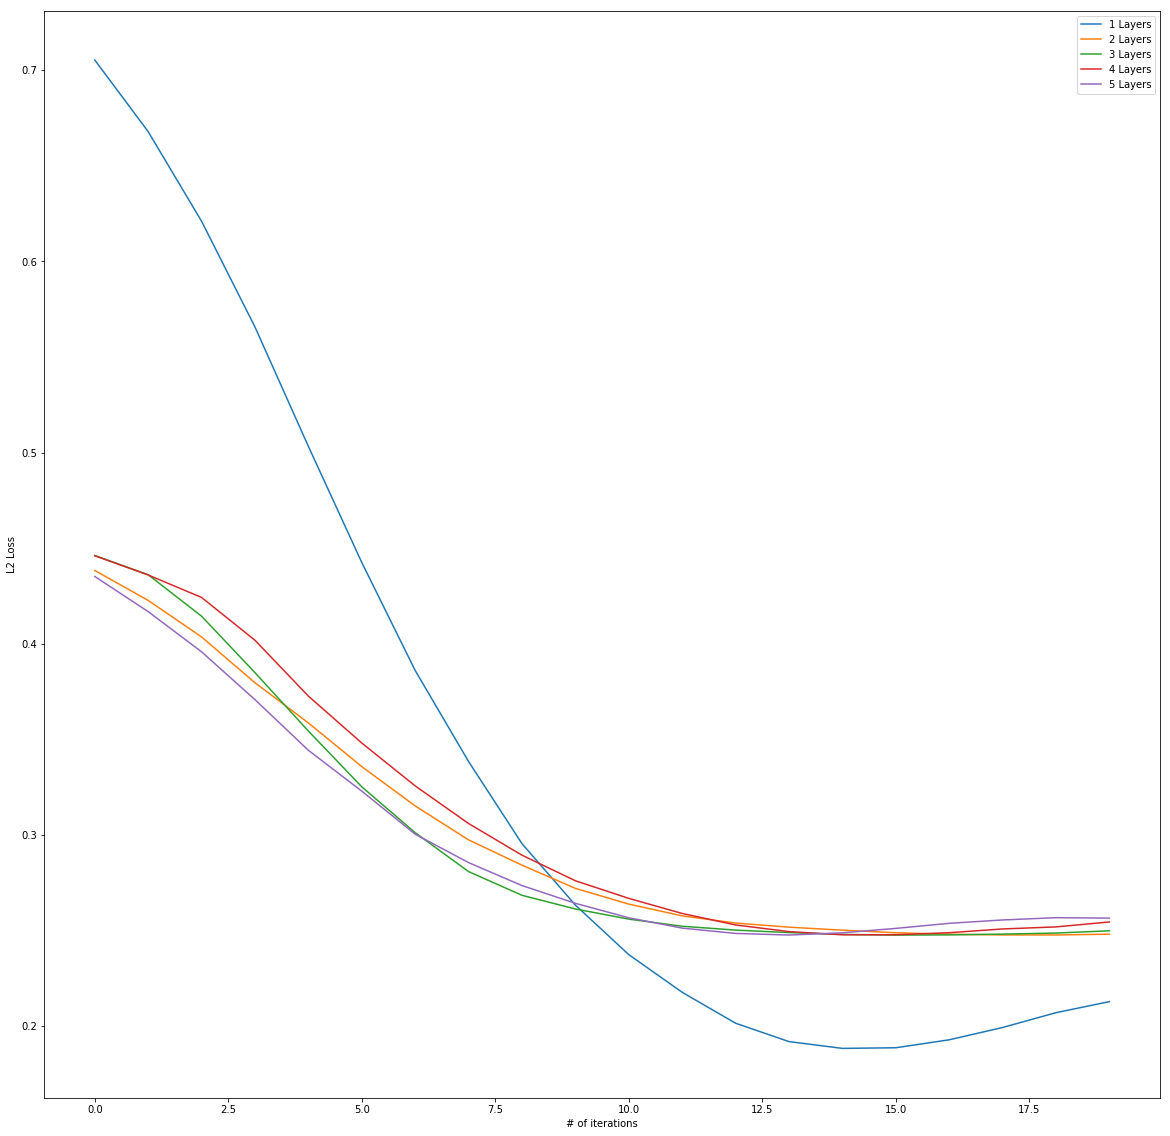

In [19]:
%matplotlib inline

plt.figure(figsize=(20,20)) 

for i, l in enumerate(num_layers):
    plt.plot(layers_costs[i], '-', label='%i Layers' % l)

plt.xlabel('# of iterations')
plt.ylabel('L2 Loss')
plt.legend(loc='best')

#plt.tight_layout()
plt.show()

In [104]:
var1 = [np.array([[[-0.01453474, -0.12898417, -0.02433007],
        [-0.00569958, -0.09413766,  0.00802958]],

       [[-0.01810061, -0.11672242, -0.01718347],
        [-0.01067066, -0.08566914, -0.00844553]],

       [[-0.03140817, -0.11196483, -0.03242999],
        [-0.01095938, -0.0726931 , -0.00563176]],

       [[-0.00986964, -0.11341817, -0.0151284 ],
        [-0.00815413, -0.06492449, -0.00469989]]]), 0.6906673783231684]

In [20]:
import time, sys
from IPython.display import clear_output

def update_progress(progress, gamma):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress ({2}): [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100, gamma)
    print(text)

In [69]:
#score = gam_train_accuracies[0][-1]
print(layers_vars)

x_min = y_min = 0
x_max = y_max = np.pi
h = 0.1  # step size in the mesh

cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

Z_dict = {}

for idx, l in enumerate(num_layers):
    Z = np.array([])

    for i, f in enumerate(grid):
        feat = np.append(f, (np.pi - f[0])*(np.pi - f[1]))
        Z = np.append(Z, np.sign(variational_classifier(layers_vars[idx], feat)))
        update_progress(i / len(grid), l)

    update_progress(1, l)
    Z = Z.reshape(xx.shape)
    Z_dict[l] = Z 
 
update_progress(1, 0.0)

Progress (0.0): [####################] 100.0%


In [25]:
#score = gam_train_accuracies[0][-1]
print(gam_vars)

x_min = y_min = 0
x_max = y_max = np.pi
h = 0.1  # step size in the mesh

cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

Z_dict = {}

for idx, g in enumerate(gammas):
    Z = np.array([])

    for i, f in enumerate(grid):
        feat = np.append(f, g * (np.pi - f[0])*(np.pi - f[1]))
        Z = np.append(Z, np.sign(variational_classifier(gam_vars[idx], feat)))
        update_progress(i / len(grid), g)

    update_progress(1, g)
    Z = Z.reshape(xx.shape)
    Z_dict[g] = Z 
 
update_progress(1, 0.0)

Progress (0.0): [####################] 100.0%


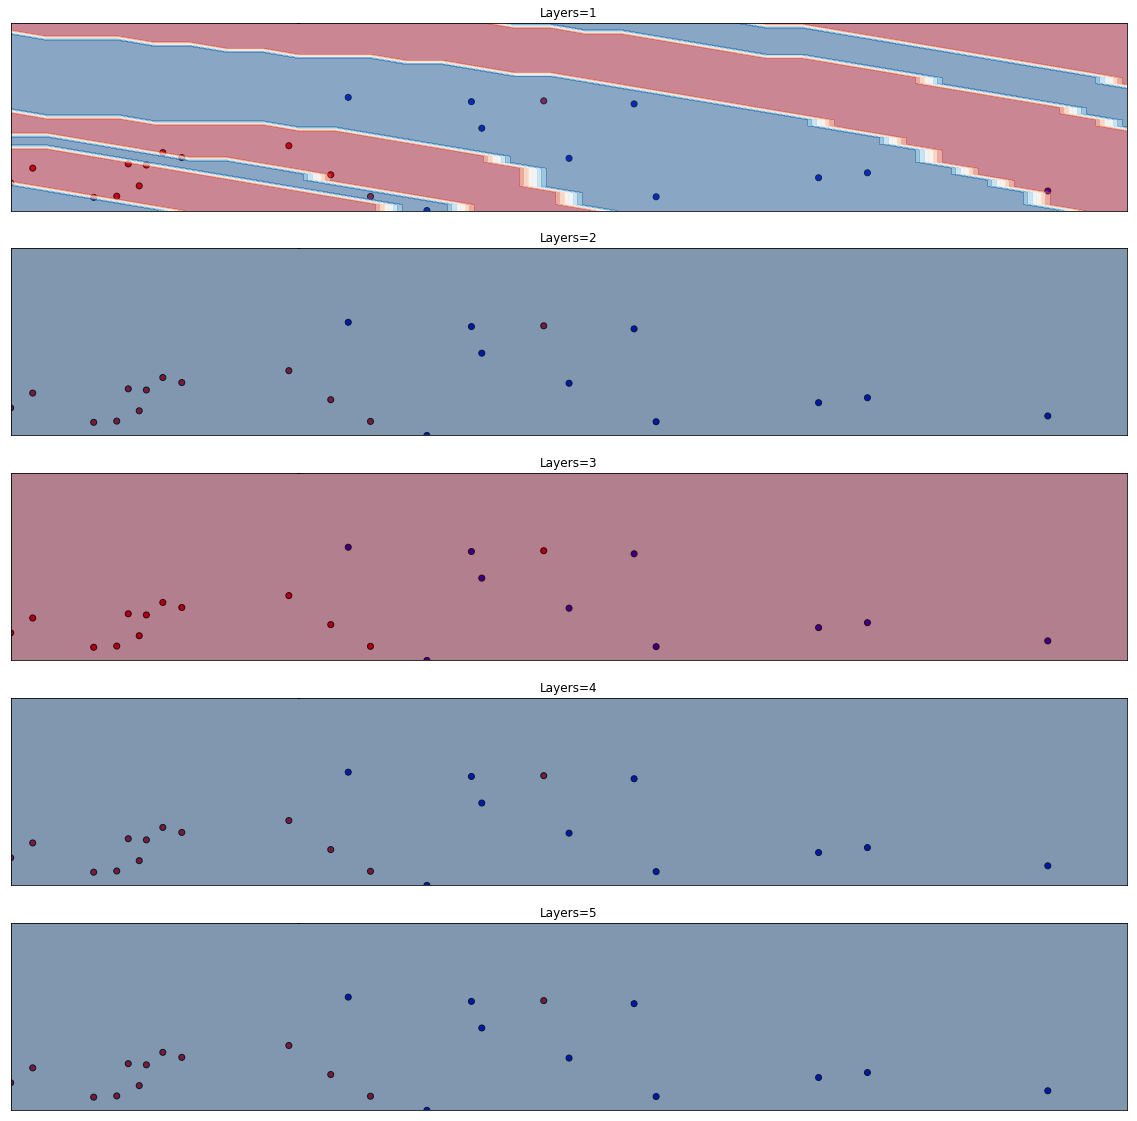

In [70]:
plt.figure(figsize=(20,20))

scores = layers_costs

for i, l in enumerate(num_layers):
    score = scores[i]
    
    plt.subplot(len(num_layers), 1, i + 1)
    plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc.target,cmap=cm_bright, edgecolors='k')
    plt.contourf(xx, yy, Z_dict[l], vmin=-1., vmax=1., cmap=cm, alpha=.5)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.title("Layers=%i" % l)

   # plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % scores[i]).lstrip('0'),
   #                 size=15, horizontalalignment='right')

plt.show()

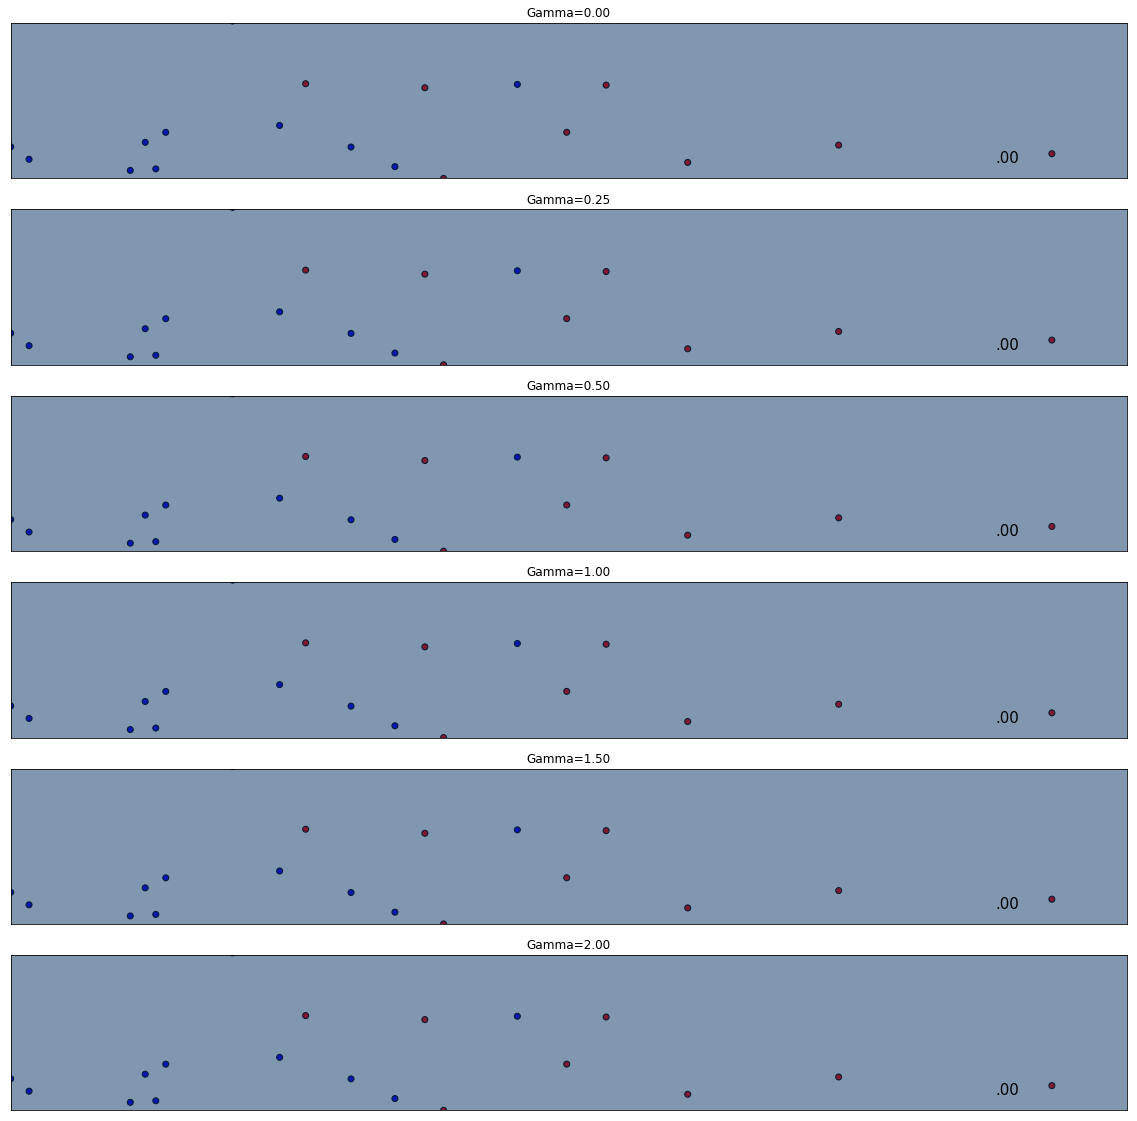

In [29]:
plt.figure(figsize=(20,20))

scores = [0.73, 0.76, 0.76, 0.87, 0.9]
for i, g in enumerate(gammas):
    score = 0.00
    
    plt.subplot(len(gammas), 1, i + 1)
    plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc.target,cmap=cm_bright, edgecolors='k')
    plt.contourf(xx, yy, Z_dict[g], vmin=-1., vmax=1., cmap=cm, alpha=.5)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.title("Gamma=%0.2f" % g)

    plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right')

plt.show()

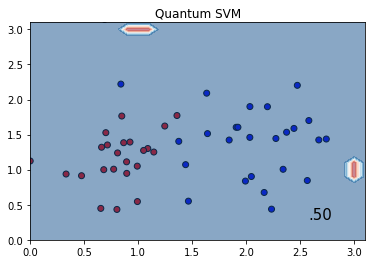

In [28]:
plt.figure()

plt.scatter(bc_proc[:,0], bc_proc[:,1], c=bc.target, cmap=cm_bright, edgecolors='k')
plt.contourf(xx, yy, Z, vmin=-1., vmax=1., cmap=cm, alpha=.5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.title("Quantum SVM")

plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')

plt.show()

In [100]:
def hada(ket):
    H = [[1, 1], [1, -1]] / np.sqrt(2)
    return np.matmul(H, ket)

def rot_Z(phi, ket):
    mat = [[np.exp(-1.j * phi) , 0], [0, np.exp(1.j * phi)]]
    return np.matmul(mat, ket)

def U_phi(x, ket1, ket2, gamma):
    ket1 = rot_Z(p[0], ket1)
    ket2 = rot_Z(p[1], ket2)
    
    phase = gamma * (np.pi - p[0]) * (np.pi - p[1])
    ket1 = rot_Z(phase, ket1)
    ket2 = rot_Z(phase, ket2)
    
    return ket1, ket2

def all_had(ket1, ket2):
    return hada(ket1), hada(ket2)

def feature_map(x, gamma):
    ket1 = [1, 0]
    ket2 = [1, 0]
    
    ket1, ket2 = U_phi(x, ket1, ket2, gamma)
    ket1, ket2 = all_had(ket1, ket2)
    ket1, ket2 = U_phi(x, ket1, ket2, gamma)
    ket1, ket2 = all_had(ket1, ket2)
    
    #print(np.linalg.norm(ket1), np.linalg.norm(ket2))
    kr = np.kron(ket1, ket2)
    #print("norm kron", np.linalg.norm(kr)) # checks out
    #print("trace of outer", np.trace(np.outer(np.conj(kr),kr))) # should be same as above
    return np.outer(np.conj(kr),kr)

ls = np.linspace(0, 2.0, 50, endpoint=True)
t = []
for g in ls:
    print("gamma: \n", g)
    pos = bc_proc[bc.target == 1]
    neg = bc_proc[bc.target != 1]

    pos_dm = np.zeros((4, 4), dtype='complex128')
    neg_dm = np.zeros((4, 4), dtype='complex128')

    for p in pos:
        u_x = feature_map(p, g)
        pos_dm +=  u_x / len(pos)

    for n in neg:
        u_x = feature_map(n, g)
        neg_dm += u_x / len(neg)

    print("trace of +1 density matrix: ", np.trace(pos_dm))
    print("trace of -1 density matrix: ", np.trace(neg_dm))
    
    print(pos_dm)
    diff = pos_dm - neg_dm
    w, v = np.linalg.eig(diff)

    #print(w)
    td = 0.5 * np.linalg.norm(w, 1)
    print("trace distance: ", td)
    t.append(td)
    
    
    

gamma: 
 0.0
trace of +1 density matrix:  (0.9999999999999991+0j)
trace of -1 density matrix:  (0.9999999999999988+0j)
[[ 2.96965864e-01+0.00000000e+00j  1.19365496e-17-2.16209693e-01j
   5.44166233e-18-1.75622203e-01j -1.53397478e-01-6.52586450e-18j]
 [ 1.19365496e-17+2.16209693e-01j  2.73368015e-01+0.00000000e+00j
   1.53397478e-01-4.87374691e-18j  8.26058798e-20-1.74966657e-01j]
 [ 5.44166233e-18+1.75622203e-01j  1.53397478e-01+4.87374691e-18j
   2.48886506e-01+0.00000000e+00j  5.22482190e-18-1.72827356e-01j]
 [-1.53397478e-01+6.52586450e-18j  8.26058798e-20+1.74966657e-01j
   5.22482190e-18+1.72827356e-01j  1.80779615e-01+0.00000000e+00j]]
trace distance:  0.3042238016258538
gamma: 
 0.04081632653061224
trace of +1 density matrix:  (0.9999999999999991+0j)
trace of -1 density matrix:  (0.9999999999999984+0j)
[[ 1.23445040e-01+0.00000000e+00j  9.87140264e-18-1.25060994e-01j
   1.28039114e-17-9.68443877e-02j -1.42949840e-01-1.88341406e-17j]
 [ 9.87140264e-18+1.25060994e-01j  2.6515684

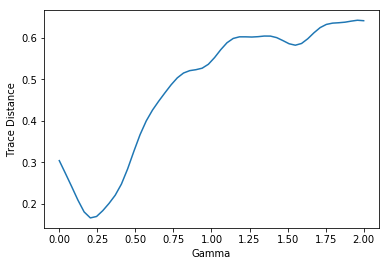

In [102]:
plt.figure()

plt.ylabel("Trace Distance")
plt.xlabel("Gamma")
plt.plot(ls, t)

plt.show()